In [179]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import Binarizer
from sklearn.decomposition import PCA

from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.metrics import classification_report, confusion_matrix
%matplotlib inline

In [115]:
import os
print(os.listdir("../dataset"))

['aps_failure_training_set_processed_8bit.csv', '.DS_Store', 'aps_failure_test_set.csv', 'aps_failure_test_set_processed_8bit.csv', 'aps_failure_training_set.csv']


In [202]:
df = pd.read_csv('../dataset/aps_failure_training_set_processed_8bit.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60000 entries, 0 to 59999
Columns: 171 entries, class to eg_000
dtypes: float64(171)
memory usage: 78.3 MB


In [117]:
df.head()

,class,aa_000,ab_000,ac_000,ad_000,ae_000,af_000,ag_000,ag_001,ag_002,...,ee_002,ee_003,ee_004,ee_005,ee_006,ee_007,ee_008,ee_009,ef_000,eg_000
0,-0.992188,0.117188,-0.289062,0.992188,-0.007812,-0.046875,-0.054688,-0.007812,-0.03125,-0.054688,...,0.687500,0.515625,0.234375,0.070312,0.007812,-0.109375,-0.140625,-0.171875,-0.023438,-0.023438
1,-0.992188,-0.179688,-0.289062,-0.468750,-0.007812,-0.046875,-0.054688,-0.007812,-0.03125,-0.054688,...,-0.023438,-0.062500,-0.132812,-0.132812,-0.187500,-0.148438,-0.085938,-0.140625,-0.023438,-0.023438
2,-0.992188,-0.125000,-0.289062,-0.468750,-0.007812,-0.046875,-0.054688,-0.007812,-0.03125,-0.054688,...,-0.140625,-0.093750,-0.015625,0.015625,-0.007812,-0.109375,-0.093750,-0.164062,-0.023438,-0.023438
3,-0.992188,-0.406250,-0.289062,-0.468750,-0.007812,-0.046875,-0.007812,-0.007812,-0.03125,-0.054688,...,-0.382812,-0.382812,-0.375000,-0.351562,-0.312500,-0.195312,-0.304688,-0.171875,0.890625,0.992188
4,-0.992188,0.007812,-0.289062,-0.468750,-0.007812,-0.046875,-0.054688,-0.007812,-0.03125,-0.054688,...,0.156250,0.031250,-0.031250,-0.039062,-0.046875,-0.015625,0.656250,-0.148438,-0.023438,-0.023438


Analizemos los valores medios y la varianza de la data

### Usar todas las columnas menos las columnas 'class' como características

In [203]:
features = df.drop(['class'], axis=1)
target = df['class']

# Dividimos el dataset para el entrenamiento 80:20 %
f_train, f_dev, t_train, t_dev = train_test_split(features, target, test_size=0.2, random_state=42)

In [173]:
np.unique(target)

array([-0.9921875,  0.9921875])

### Como se usan numeros reales, se necesita binarizar en dos clases: 0 normal 1 falla

In [204]:
# threshold classes into 0 and 1(failure)
lb = Binarizer()
lb.fit(t_train.values.reshape(-1, 1))
t_train_bi = lb.transform(t_train.values.reshape(-1, 1))
t_dev_bi = lb.transform(t_dev.values.reshape(-1, 1))

In [189]:
np.unique(t_train_bi)

array([0., 1.])

### Para usar PCA necesitamos normalizar la data ya que se encuentra escalada

In [190]:
# Normalizando con el método estándar
# scaler = StandardScaler()
# scaler.fit(f_train)
# f_nor_train = scaler.transform(f_train)
# f_nor_dev = scaler.transform(f_dev)

# Seleccionando los principales componentes con el PCA
# pca = PCA(n_components=60)
# pca.fit(f_nor_train)
# f_pca_train = pca.transform(f_nor_train)
# f_pca_dev = pca.transform(f_nor_dev)

In [211]:
from sklearn.preprocessing import scale
f_train_norm = scale(f_train)
f_dev_norm = scale(f_dev)
# pd.DataFrame(X_norm, index=features.index, columns=features.columns).head()

In [210]:
# Comparemos los datos con y sin normalización:
print('Antes de normalizar:\n', f_train[:2])
print('\nDespués de normalizar:\n', f_train_norm[:2])

In [212]:
from sklearn.decomposition import PCA
pca = PCA().fit(f_train_norm)

f_nor_train = pca.transform(f_train_norm)
f_nor_dev = pca.transform(f_dev_norm)

In [213]:
print "Number of components ", pca.n_components_

Number of components  170


### Gráfico de la varianza

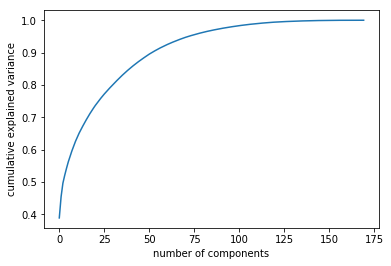

In [239]:
# Varianza de los componentes principales
# plt.bar(pca.explained_variance_)

plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance');

### Generamos el training and test set

In [216]:
# Separando data de entrenamiento y prueba
X_train = f_pca_train
X_dev = f_pca_dev
y_train = t_train_bi.reshape(-1,1)
y_dev = t_dev_bi.reshape(-1,1)

### Entrenamos Linear Regression

In [217]:
LR = LinearRegression()
LR.fit(X_train, y_train)
prediction = LR.predict(X_dev)
pred = (prediction > 0.5).astype(int)
print(classification_report(y_dev, pred))

             precision    recall  f1-score   support

        0.0       0.99      1.00      0.99     11788
        1.0       0.82      0.38      0.52       212

avg / total       0.99      0.99      0.99     12000



In [218]:
resultado = confusion_matrix(y_dev, pred)
print(resultado)

[[11770    18]
 [  131    81]]


### Resultado

In [219]:
print "Falsos negativos",resultado[1,0]
print "Falsos positivos",resultado[0,1]
print "Costo total", (resultado[1,0]*500 + resultado[0,1]*10)

Falsos negativos 131
Falsos positivos 18
Costo total 65680


### Entrenamos Regresión Logística

In [220]:
LR = LogisticRegression()
LR.fit(X_train, y_train)

predictions = LR.predict(X_dev)
pred = (predictions > 0.5).astype(int)
print(classification_report(y_dev, pred))

             precision    recall  f1-score   support

        0.0       0.99      1.00      0.99     11788
        1.0       0.76      0.52      0.62       212

avg / total       0.99      0.99      0.99     12000



In [221]:
resultado = confusion_matrix(y_dev, pred)
print(resultado)

[[11753    35]
 [  102   110]]


In [222]:
print "Falsos negativos",resultado[1,0]
print "Falsos positivos",resultado[0,1]
print "Costo total", (resultado[1,0]*500 + resultado[0,1]*10)

Falsos negativos 102
Falsos positivos 35
Costo total 51350
